# L'heure de la modèlisation hydrologique est arrivée
Et voilá. La suppréssion de biais finalisée, la modèlisation hydrologique peut commencer.

L'util de modèlisation 

In [31]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from modules.multi_window_mapper import Multi_Window_Mapper
from modules.quantile_mapping import QuantileMapper, QuantileMapping, QuantileDeltaMapping

# Pour supprimer des avertissements
import warnings
warnings.filterwarnings('ignore')

### Charger les données des projections et les données historiques
`data/projections.csv` et `data/historical_data.csv`

In [42]:
historical_data_file = Path(r'data/historical_data.csv')
projections_file = Path(r'data/projections.csv')

projections = pd.read_csv(projections_file, index_col=0, header = [0, 1, 2, 3], skiprows=[4], parse_dates=[0], date_format='%Y-%m-%d')
historical = pd.read_csv(historical_data_file, index_col=0, header = [0, 1], parse_dates=[0], date_format='%Y-%m-%d')

# Chagement des colonnes pour qu'elles soient similaires à celles de projections
columns = historical.columns.to_frame(index=False)
columns.loc[:, 'Zone'] = columns.loc[:, 'Zone'].map(lambda x: x[0] + x[1:].lower())
columns.loc[:, 'Variables'] = columns.loc[:, 'Variables'].map(lambda x: {'P [mm]': 'pr', 'T [C]': 'tas', 'Hobs [mm]':'hobs', 'Hsim [mm]':'hsim'}[x])
historical.columns = pd.MultiIndex.from_frame(columns)
historical

Zone             Q11b                                         Q12  \
Variables          pr       hsim       hobs        tas         pr   
1990-09-01  10.492857   0.000000   0.041793  23.413880   8.340541   
1990-10-01  27.050000   0.000000   0.132855  18.827589  26.362162   
1990-11-01  41.857143   1.625004   0.637774  15.145339  42.221622   
1990-12-01  78.000000  21.968107   2.738655  12.706330  79.556757   
1991-01-01  18.292857   6.194848   0.395848  10.445206  13.737838   
...               ...        ...        ...        ...        ...   
2022-08-01   0.485714   0.050903   0.315086  23.759148   0.810811   
2022-09-01   4.642857   0.019343   0.175626  21.719179   4.689189   
2022-10-01   4.778571   0.007350   0.208142  22.873667   7.883784   
2022-11-01   6.392857   0.002793   0.542631  17.134014   8.113514   
2022-12-01  45.721429   2.058103  14.969000  15.688480  77.870270   

Zone                                                Q14a                ...  \
Variables           hsim      hobs        tas         pr          hsim  ...   
1990-09-01  0.000000e+00  0.022882  23.413880   9.329167  0.000000e+00  ...   
1990-10-01  0.000000e+00  0.028479  18.827589  26.420833  0.000000e+00  ...   
1990-11-01  1.160168e+00  0.324303  15.145339  33.166667  3.429533e-01  ...   
1990-12-01  6.549536e+00  1.729672  12.706330  71.850000  4.230383e+00  ...   
1991-01-01  0.000000e+00  0.061239  10.445206   7.616667  0.000000e+00  ...   
...                  ...       ...        ...        ...           ...  ...   
2022-08-01  6.550513e-08  0.009015  23.759148   0.600000  3.260627e-22  ...   
2022-09-01  2.489195e-08  0.000000  21.719179   4.175000  1.239038e-22  ...   
2022-10-01  9.458941e-09  0.000000  22.873667  11.808333  4.708345e-23  ...   
2022-11-01  3.594398e-09  0.000000  17.134014   5.587500  1.789171e-23  ...   
2022-12-01  6.306090e+00  0.000000  15.688480  80.762500  5.126033e+00  ...   

Zone              Q4b                     Q7                          \
Variables        hobs        tas          pr          hsim      hobs   
1990-09-01   1.107172  23.509356   28.716541  0.000000e+00  0.086771   
1990-10-01   0.264993  17.065509   39.496241  0.000000e+00  0.118819   
1990-11-01   0.082315  12.983124   49.433083  1.002130e+00  0.257325   
1990-12-01   8.134774   9.451887  112.993985  1.319199e+01  7.146044   
1991-01-01   0.243488   7.998259    8.097744  1.465035e+00  0.752594   
...               ...        ...         ...           ...       ...   
2022-08-01   0.149874  28.263870    8.063910  5.420737e-08  0.001124   
2022-09-01   0.870828  22.890739   22.679699  2.059880e-08  0.000000   
2022-10-01   7.008391  22.249683   37.715038  7.827545e-09  0.000000   
2022-11-01   0.046064  16.322276    7.100752  2.974467e-09  0.000000   
2022-12-01  10.000392  12.366718  102.235338  7.925896e+00  3.523253   

Zone                           Q8                                     
Variables         tas          pr          hsim      hobs        tas  
1990-09-01  22.598050   26.657143  0.000000e+00  0.085297  22.443770  
1990-10-01  16.201201   47.060714  0.000000e+00  0.116800  16.088638  
1990-11-01  12.148505   51.664286  5.194005e-01  0.252953  12.258947  
1990-12-01   9.057656  106.571429  9.784010e+00  7.024635   9.357754  
1991-01-01   7.347046    9.785714  0.000000e+00  0.739808   7.589206  
...               ...         ...           ...       ...        ...  
2022-08-01  26.553124   10.960714  1.723262e-06  0.001105  25.355905  
2022-09-01  21.583001   27.671429  6.548397e-07  0.000000  20.953837  
2022-10-01  21.325195   43.285714  2.488391e-07  0.000000  21.292596  
2022-11-01  15.438855    9.942857  9.455886e-08  0.000000  15.351671  
2022-12-01  12.142912   89.950000  6.979438e+00  3.463394  12.555421  

[388 rows x 52 columns]

### Ciblons une projection en particulier
Le "Quantile Mappint" est appliqué à une projection à la fois.  
Nous avons besoin de:
- Définir le cas (rcp45 ou rcp85).
- Définir le modèle.
- Choisir le bassin versant.
- Une référence historique.
- La "projection" pour la période historique.
- La projection future.

Pensant à l'utilisation future, la procédure de séléction sera mise en forme par une fonction

,pr,tas
1960-09-01,15.919318,21.391099
1960-10-01,39.087262,21.360341
1960-11-01,15.247278,14.942034
1960-12-01,32.147193,13.156899
1961-01-01,3.215198,11.728381
...,...,...
2100-08-01,0.752575,27.955427
2100-09-01,0.112500,27.243966
2100-10-01,18.477004,25.065932
2100-11-01,49.712809,20.524160


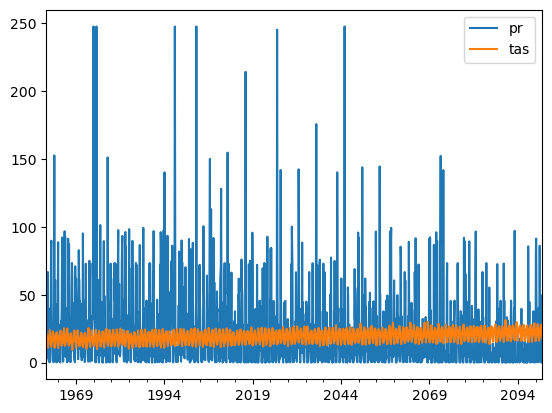

In [56]:
cas = 'rcp85'
modele = 'CCCma-CanESM2_r1i1p1_SMHI-RCA4_v1'
bv = 'Q18'

def apply_quantile_mapping(cas, modele, bv):
    '''

    '''
    
    tas_historical_bv = historical.loc[:, (bv, 'tas')]
    tas_projection_historical_bv = projections.loc[:, ('tas', 'historical', bv, modele)]
    tas_projection_bv = projections.loc[:, ('tas', cas, bv, modele)]
    tas_projection_bv = pd.concat((tas_projection_bv, tas_projection_historical_bv), axis=1).bfill(axis=1).iloc[:, [0]].sort_index()
    
    pr_historical_bv = historical.loc[:, (bv, 'pr')]
    pr_projection_bv = projections.loc[:, ('pr', cas, bv, modele)]
    pr_projection_historical_bv = projections.loc[:, ('pr', 'historical', bv, modele)]
    pr_projection_bv = pd.concat((pr_projection_bv, pr_projection_historical_bv), axis=1).bfill(axis=1).iloc[:, [0]].sort_index()
    
    # Température
    kw_kernel = {'model': QuantileDeltaMapping, # Le type de Quantile Mapping à utiliser
                 'kw_model': {'trend_window': 10, # la fenêtre pour le calcul du "delta"
                              'transformation': 'additive',
                              'modified': False,
                             },
                }     
    qm = QuantileMapper(projection_historical=tas_projection_bv, reference=tas_historical_bv,
                        kernel=Multi_Window_Mapper, kw_kernel=kw_kernel,
                        trend_window=5, # Le nombre d'années condidérées pour la moyenne glissante
                        hydrological_year_month_start=9)
    qm.map()
    tas_corrected = qm.apply(tas_projection_bv)

    # Précipitation
    kw_kernel = {'model': QuantileMapping, # Le type de Quantile Mapping à utiliser
            } 
    qm = QuantileMapper(projection_historical=pr_projection_bv, reference=pr_historical_bv,
                        kernel=Multi_Window_Mapper, kw_kernel=kw_kernel,
                        trend_window=5, # Le nombre d'années condidérées pour la moyenne glissante
                        hydrological_year_month_start=9)
    qm.map()
    pr_corrected = qm.apply(pr_projection_bv)
    
    return pd.concat((pr_corrected, tas_corrected), keys=['pr', 'tas'], axis=1).loc['1960-09-01':,:]

corrected = apply_quantile_mapping(cas, modele, bv)
corrected.plot()
corrected

### Interaction avec le modèle hydrologique

a

In [75]:
import shutil
import openpyxl

hydrological_folder = Path(r'hydrology/results') / bv / cas / modele
hydrological_folder.mkdir(parents=True, exist_ok=True) # Créer le nouveau dossier

template_hydrological_model = Path(r'hydrology/template_model.xlsx')
active_hydrological_model = hydrological_folder / 'model.xlsx'

# Faire une copie du modèle de base
_ = shutil.copy(template_hydrological_model, active_hydrological_model)  # For Python 3.8+.

# Trouver le modèle du bassin versant
calibrated_hydrological_model = [i for i in Path(r'hydrology/base models/').glob(f'MODEL - pluie - débit {bv} *.xlsx')]
if len(calibrated_hydrological_model)!=1:
    raise(Exception(f'Problems with the basin "{bv}". Does the model exist?'))
calibrated_hydrological_model = calibrated_hydrological_model[0]

### 

In [77]:
workbook = openpyxl.load_workbook(active_hydrological_model)
sheet = workbook.active
print(sheet)

# Read a specific cell value
cell_value = sheet['B2'].value
print(f'Original Value: {cell_value}')

<Worksheet "MODEL - pluie - débit">
Original Value: None
